In [1]:
import numpy as np
import pyradiosky
import astropy.units as units
from astropy.units import Quantity
from astropy.coordinates import (
    Latitude,
    Longitude
)
import matplotlib.pyplot as plt

In [2]:
path_to_npz = '/Users/ruby/Astro/rlb_LWA/LWA_skymodels/sourcecatalog.npz'

In [3]:
cat_data = np.load(path_to_npz)

In [4]:
cat_data.__dict__

{'_files': ['rms_abs.npy',
  'bpa_abs.npy',
  'bmaj_abs.npy',
  'ra_abs.npy',
  'bmin_abs.npy',
  'pkflux_abs.npy',
  'dec_abs.npy'],
 'files': ['rms_abs',
  'bpa_abs',
  'bmaj_abs',
  'ra_abs',
  'bmin_abs',
  'pkflux_abs',
  'dec_abs'],
 'allow_pickle': False,
 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True},
 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='/Users/ruby/Astro/rlb_LWA/LWA_skymodels/sourcecatalog.npz'> mode='r'>,
 'f': <numpy.lib.npyio.BagObj at 0x7ff47018ae50>,
 'fid': <_io.BufferedReader name='/Users/ruby/Astro/rlb_LWA/LWA_skymodels/sourcecatalog.npz'>}

In [5]:
Ncomponents = np.shape(cat_data['ra_abs'])[0]
Nfreqs = 1
freq_hz = 56.*10**6
ra = Longitude(cat_data['ra_abs'], units.deg)
dec = Latitude(cat_data['dec_abs'], units.deg)
stokes = Quantity(np.zeros((4, Nfreqs, Ncomponents), dtype=float), 'Jy')
stokes[0,0,:] = cat_data['pkflux_abs'] * units.Jy
reference_frequency=Quantity(np.full(Ncomponents, freq_hz), "hertz")
spectral_index = np.full(Ncomponents, -0.8)
name = [f'LWA_sourcecatalog_{str(source_ind).zfill(4)}' for source_ind in range(Ncomponents)]
catalog = pyradiosky.SkyModel(
    name=name,
    ra=ra,
    dec=dec,
    stokes=stokes,
    spectral_type="spectral_index",
    reference_frequency=reference_frequency,
    spectral_index=spectral_index,
)
catalog.check()

True

In [6]:
named_sources = {
    'Crab': {'ra':83.6331, 'dec':22.0145}, 
    'PicA': {'ra':79.9572, 'dec':-45.7788},
    'HydA': {'ra':139.524, 'dec':-12.0956},
    'CenA': {'ra':201.365, 'dec':-43.0192},
    'HerA': {'ra':252.784, 'dec':4.9925},
    'VirA': {'ra':187.706, 'dec':12.3911},
    'CygA': {'ra':299.868, 'dec':40.7339},
    'CasA': {'ra':350.858, 'dec':58.8},
    '3C161': {'ra':96.7921, 'dec':-5.88472},
    '3C353': {'ra':260.117, 'dec':-0.979722},
    '3C409': {'ra':303.615, 'dec':23.5814},
    '3C444': {'ra':333.607, 'dec':-17.0267},
    'CasA': {'ra':350.866, 'dec':58.8117},
    'ForA': {'ra':50.6738, 'dec':-37.2083},
    'HerA': {'ra':252.793, 'dec':4.99806},
    'NGC0253': {'ra':11.8991, 'dec':-25.2886},
    'PicA': {'ra':79.9541, 'dec':-45.7649},
    'VirA': {'ra':187.706, 'dec':12.3786},
    'PKS0349-27': {'ra':57.8988, 'dec':-27.7431},
    'PKS0442-28': {'ra':71.1571, 'dec':-28.1653},
    'PKS2153-69': {'ra':329.275, 'dec':-69.6900},
    'PKS2331-41': {'ra':353.609, 'dec':-41.4233},
    'PKS2356-61': {'ra':359.768, 'dec':-60.9164},
    'PKSJ0130-2610': {'ra':22.6158, 'dec':-26.1656}
}

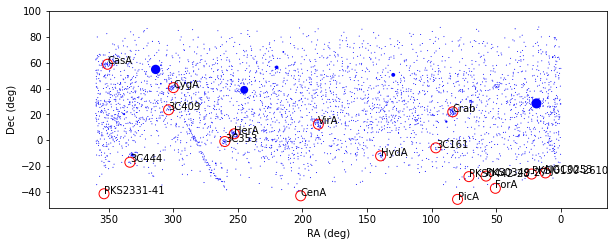

In [7]:
# Plot catalog
ra_range = None
dec_range = None
label_sources = True
label_source_names = None
ra_cut_val = 0.

source_fluxes = catalog.stokes[0, 0, :].value
flux_plot_max = max(source_fluxes)
source_markersizes = []
markersize_range = [1., 100.]
for flux in source_fluxes:
    if flux >= flux_plot_max:
        flux = flux_plot_max
    source_markersizes.append(
        flux/flux_plot_max*(markersize_range[1] - markersize_range[0])
        + markersize_range[0]
    )
    
source_ras = catalog.ra.value
source_decs = catalog.dec.value

if ra_range is None:
    ra_min = min(source_ras)
    ra_max = max(source_ras)
    ra_range = [
        ra_min-(ra_max-ra_min)/10., ra_max+(ra_max-ra_min)/10.
    ]
if dec_range is None:
    dec_min = min(source_decs)
    dec_max = max(source_decs)
    dec_range = [
        dec_min-(dec_max-dec_min)/10., dec_max+(dec_max-dec_min)/10.
    ]

plt.figure(figsize=(10,10))
ax = plt.gca()
plt.scatter(
    source_ras, source_decs, s=source_markersizes, facecolors='blue',
    edgecolors='none'
    )

if label_sources:
    if label_source_names is None:
        label_source_names = list(named_sources.keys())
    named_source_ras = [named_sources[name]['ra'] for name in label_source_names]
    named_source_decs = [named_sources[name]['dec'] for name in label_source_names]
    plt.scatter(
        named_source_ras, named_source_decs, marker='o',
        s=markersize_range[1], facecolors='none', edgecolors='red',
        linewidth=1
    )
    for i, name in enumerate(label_source_names):
        plt.annotate(
            name, (named_source_ras[i], named_source_decs[i]),
            fontsize=10.
        )

plt.xlim(ra_range[1], ra_range[0])
plt.ylim(dec_range[0], dec_range[1])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
ax.set_aspect('equal', adjustable='box')
ax.set_facecolor('white')
plt.savefig('/Users/ruby/Desktop/source_plot.png', format='png', dpi=600)
plt.show()